In [1]:
import numpy as np
from time import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import pdspy.modeling as modeling
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.animation import FuncAnimation
import os
import pickle

/users/eteng/software/et_env/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### read in data

In [2]:
param_names = ["Tstar","logLstar","logMdisk","logRdisk","h0","logRin","gamma",\
               "beta","logMenv","logRenv","fcav","ksi","logamax","p","incl"]
pnt = ["Tstar","logLstar","logMdisk","logRdisk","h0","logRin","gamma_t",\
               "bix","logMenv_t","logRenv","fcav","ksi","logamax","p","biy"]

seds_dict=np.load("./etgrid/et_dictionary_seds.npy",allow_pickle=True)

seds=np.load("./etgrid/seds.npy",allow_pickle=True)[:,100:500]
nanseds=np.load("./etgrid/seds.npy",allow_pickle=True)[:,100:500]
xvals=np.load("./etgrid/xvals.npy",allow_pickle=True)

# fix -infs: powerlaw cutoff
for i in range(len(seds)):
    if -np.inf in seds[i]:
        a = seds[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = seds[i][ind]
        for j in range(ind):
            seds[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# subtracting from each SED its sample mean
nanseds[nanseds<-20]=np.nan
seds_msub = seds - np.nanmean(nanseds,axis=1)[:,np.newaxis]

# run PCA
pca = PCA(n_components=40).fit(seds_msub)
print("PCA finished")
eigenseds=np.array(pca.components_)

PCA finished


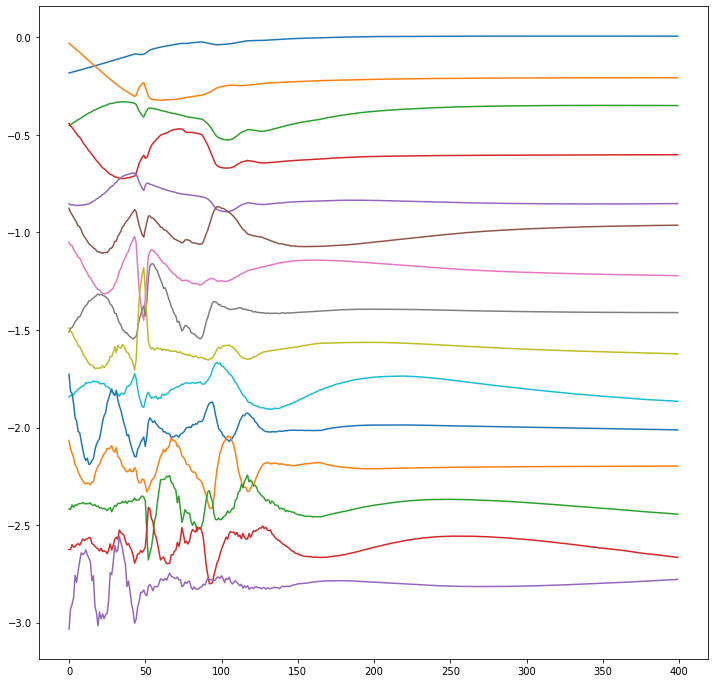

In [3]:
plt.figure(figsize=(12,12))
for i in range(15):
    plt.plot(eigenseds[i]-0.2*i)

### read in slice data

In [4]:
# slices - read in filenames and logspace flux values
slicevals = np.load("new_slicevals.npy")
nanslicevals = np.load("new_slicevals.npy")
sliceparams=np.load("new_sliceparams.npy")

In [5]:
#np.save("new_slicevals.npy",slicevals)
#np.save("new_sliceparams.npy",steps)

In [6]:
# fix -infs: powerlaw cutoff
for i in range(len(slicevals)):
    for j in range(len(slicevals[i])):
        if -np.inf in slicevals[i][j]:
            a = slicevals[i][j].tolist()
            a.reverse()
            ind = len(a)-a.index(-np.inf)
            x1 = xvals[ind]
            y1 = slicevals[i][j][ind]
            for m in range(ind):
                slicevals[i][j][m]=(100*(np.log10(xvals[m]/x1)))+y1
                
nanslicevals[nanslicevals<-20]=np.nan

# subtracting from the seds each sample mean
slice_seds_msub = slicevals - np.nanmean(nanslicevals,axis=2)[:,:,np.newaxis]

### fit slices

In [7]:
fitdata=[]

for i in range(15):
    fitdata.append([])

In [8]:
for i in range(15):
    for j in range(len(slicevals[i])):
        modeldata=[]
        paramval=sliceparams[i][j]
        coeffs=pca.transform(slice_seds_msub[i][j].reshape(1,-1))
        modeldata.append(paramval)
        for k in range(10):
            modeldata.append(coeffs[0][k])
        fitdata[i].append(modeldata)

In [9]:
np.array(fitdata).shape

(15, 11, 11)

In [12]:
np.save("new_fitdata.npy",fitdata)

In [11]:
sliceparams.shape

(15, 11)

In [82]:
#for i in range(6,10):
#    print(i)
#    for j in range(15):
#        vals=np.array(fitdata)[j,:,i+1]
#        print(np.round(np.max(vals)-np.min(vals),3))

In [83]:
def orig_to_trans(pars):
    gamma=pars[6]
    logM_env=pars[8]
    beta=pars[7]
    incl=pars[14]
    
    pars[6]=np.log10(2.1-1*gamma)
    pars[8]=np.log10(-1.5-1*logM_env)
    
    s=np.sin(0.7)
    c=np.cos(0.7)
    
    pars[7]=1-np.cos(((beta*c) + (incl*s/60)-.5)*np.pi/2)
    pars[14]=(-beta*s) + (incl*c/60)
    return pars

### plot coefficient values against parameter values

In [84]:
def plotpcwpar(param,coeffindex):
    fig,ax=plt.subplots(1,figsize=(12,9))
    pvals=[]
    cvals=[]
    for i in range(11):
        pvals.append(fitdata[param][i][0])
        cvals.append(fitdata[param][i][coeffindex+1])
    ax.scatter(pvals,cvals)
    plt.title("principal component #"+str(coeffindex)+" weight versus "+param_names[param],fontsize=16)
    plt.ylabel("w"+str(coeffindex),fontsize=16)
    plt.xlabel(param_names[param],fontsize=16)
    plt.show()    

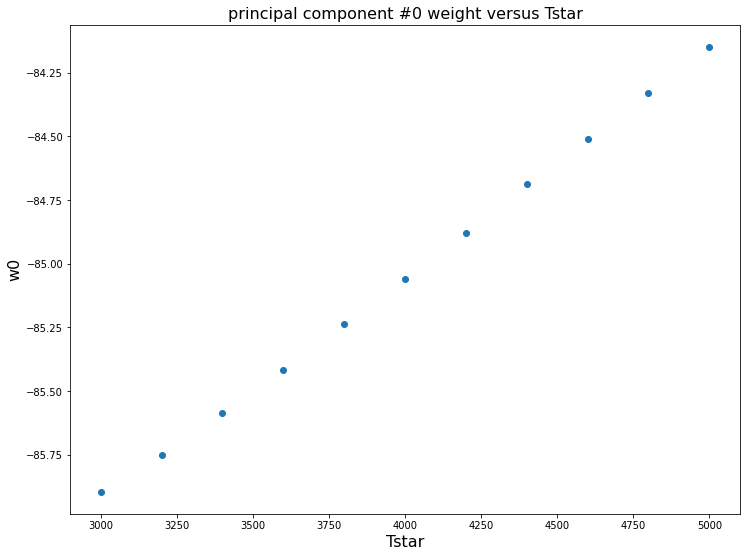

In [85]:
plotpcwpar(0,0)

In [86]:
def plotpcwpar_all(param):
    #pdf = PdfPages("../visualization/pcwpar/"+param_names[param]+"_pcwpar.pdf")
    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(8,12))
    
    for coeffindex in range(10):
        pvals=[]
        cvals=[]
        for i in range(11):
            pvals.append(fitdata[param][i][0])
            cvals.append(fitdata[param][i][coeffindex+1])
            
        ax[coeffindex//2][coeffindex%2].scatter(pvals,cvals)
        ax[coeffindex//2][coeffindex%2].set_xlabel(param_names[param])
        ax[coeffindex//2][coeffindex%2].set_ylabel("w"+str(coeffindex))
    
    plt.subplots_adjust(hspace=0.6)
    plt.subplots_adjust(wspace=0.7)
    plt.show()
    
    plt.clf()

    print("principal component weight/parameter plots generated for ", param_names[param])

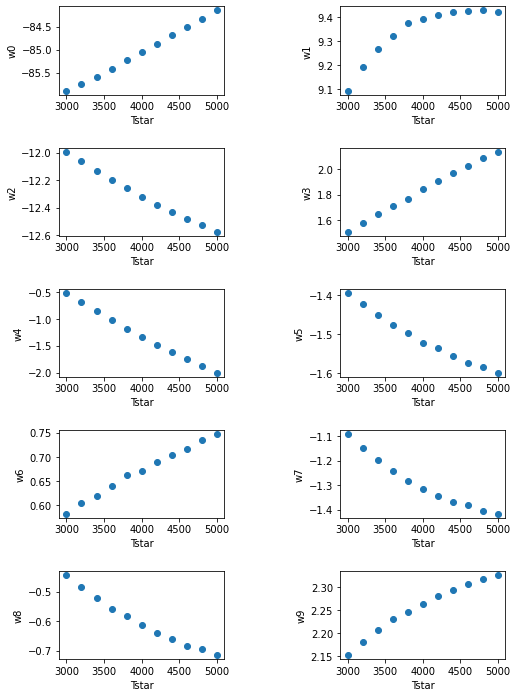

principal component weight/parameter plots generated for  Tstar


<Figure size 432x288 with 0 Axes>

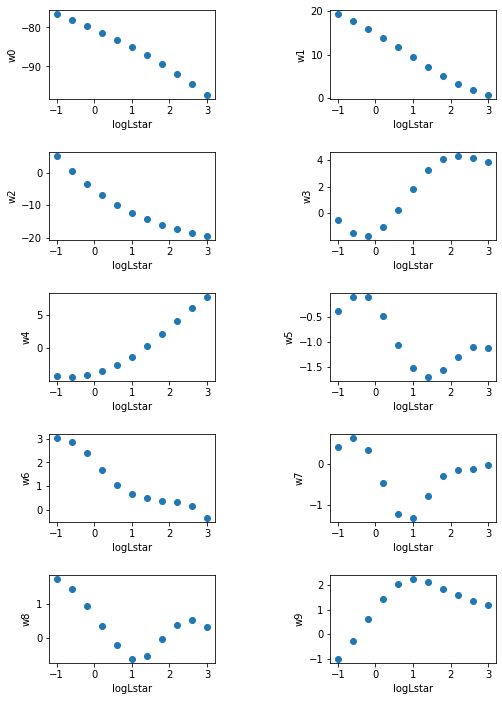

principal component weight/parameter plots generated for  logLstar


<Figure size 432x288 with 0 Axes>

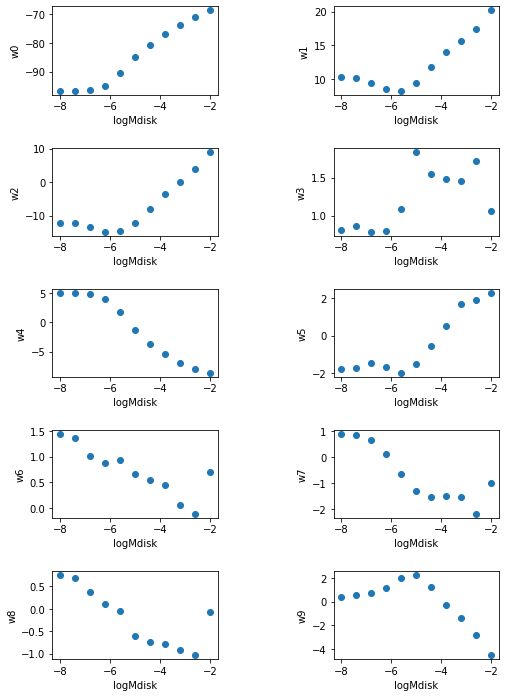

principal component weight/parameter plots generated for  logMdisk


<Figure size 432x288 with 0 Axes>

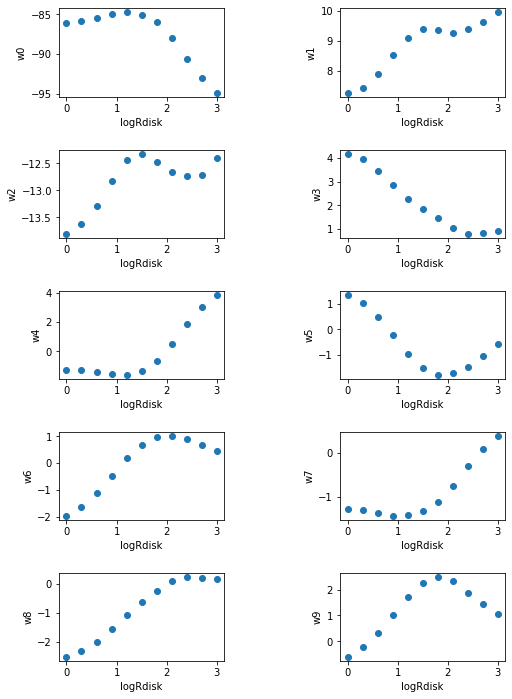

principal component weight/parameter plots generated for  logRdisk


<Figure size 432x288 with 0 Axes>

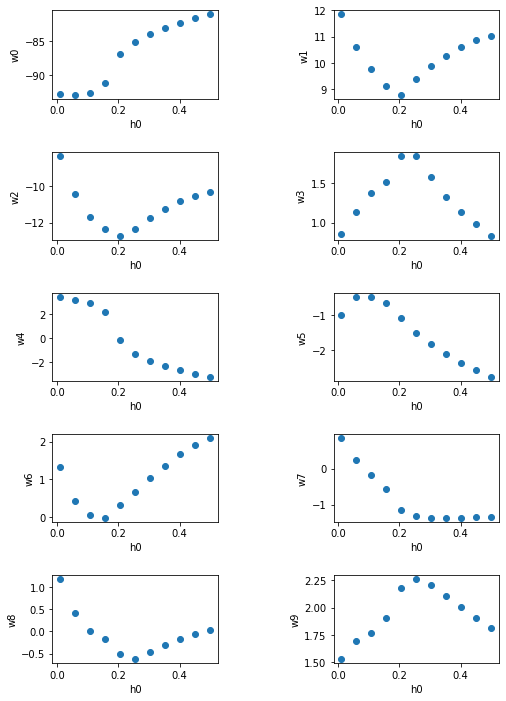

principal component weight/parameter plots generated for  h0


<Figure size 432x288 with 0 Axes>

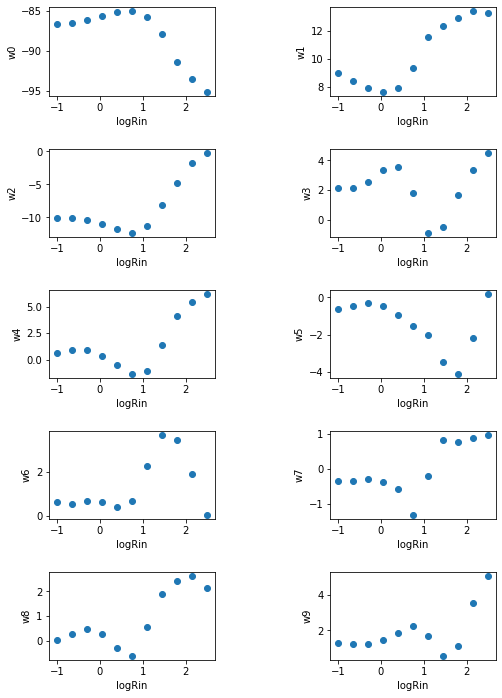

principal component weight/parameter plots generated for  logRin


<Figure size 432x288 with 0 Axes>

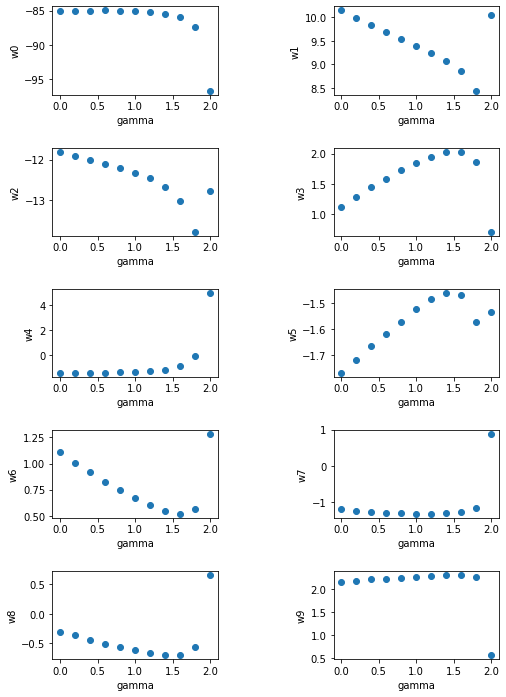

principal component weight/parameter plots generated for  gamma


<Figure size 432x288 with 0 Axes>

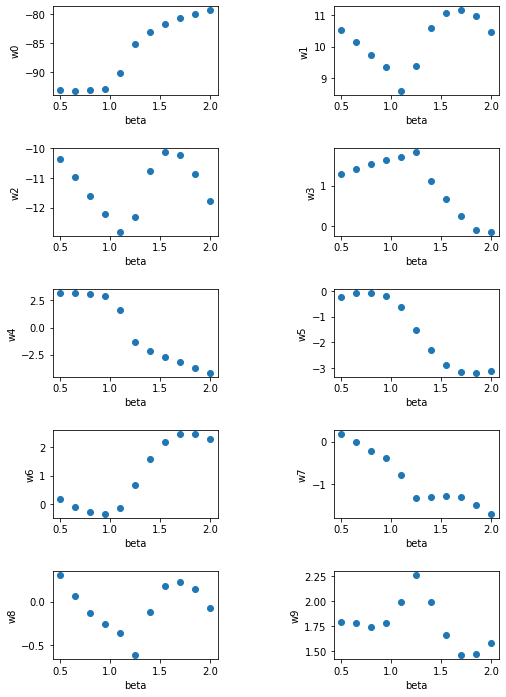

principal component weight/parameter plots generated for  beta


<Figure size 432x288 with 0 Axes>

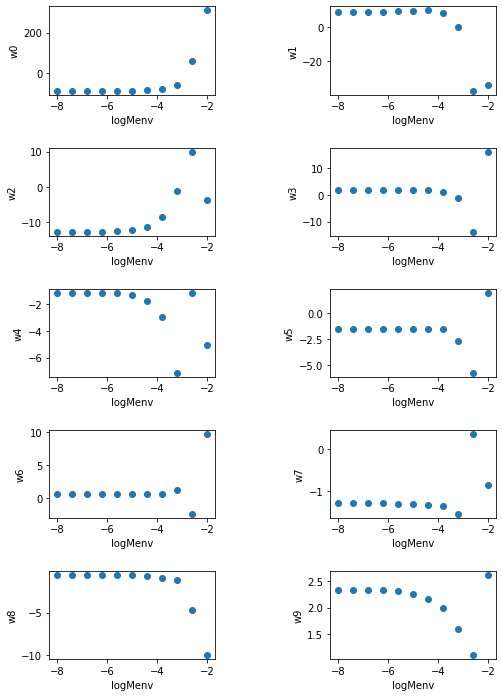

principal component weight/parameter plots generated for  logMenv


<Figure size 432x288 with 0 Axes>

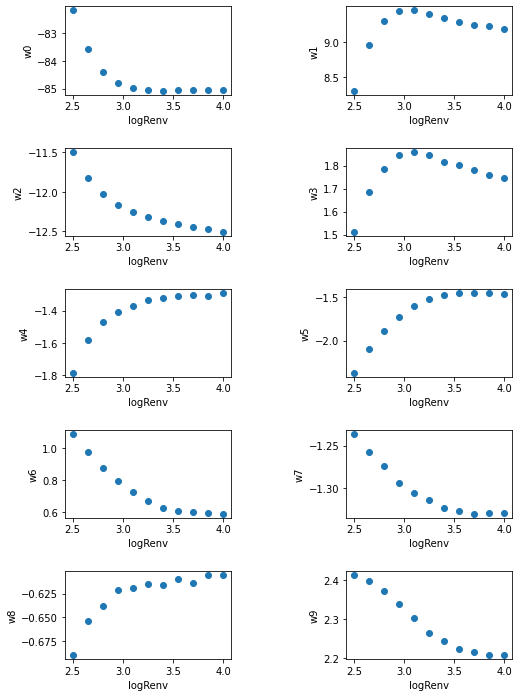

principal component weight/parameter plots generated for  logRenv


<Figure size 432x288 with 0 Axes>

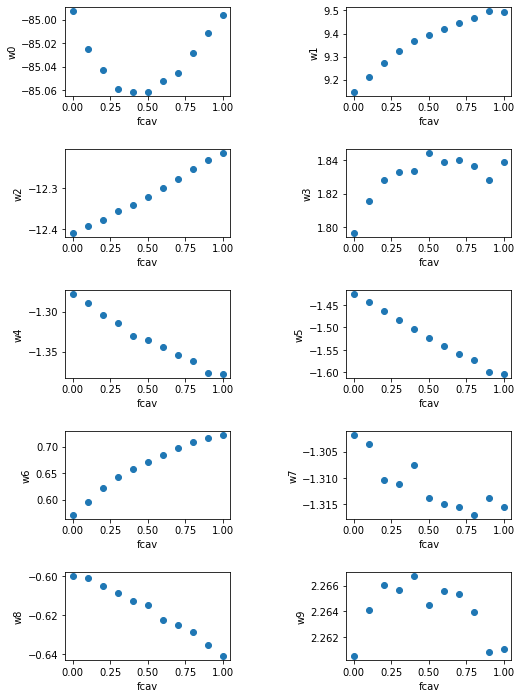

principal component weight/parameter plots generated for  fcav


<Figure size 432x288 with 0 Axes>

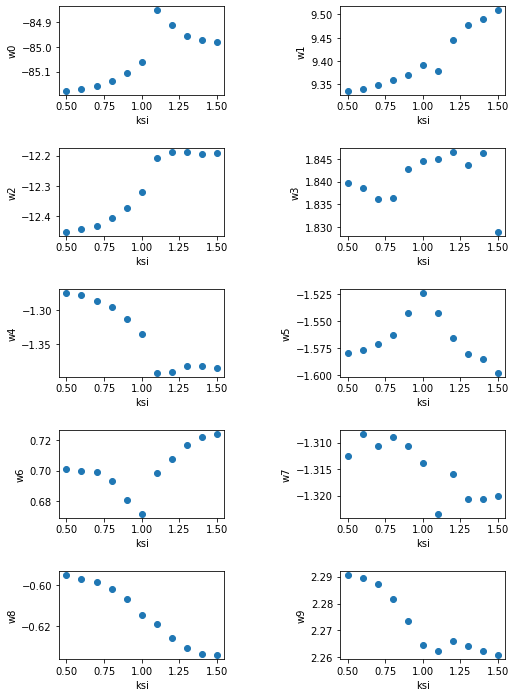

principal component weight/parameter plots generated for  ksi


<Figure size 432x288 with 0 Axes>

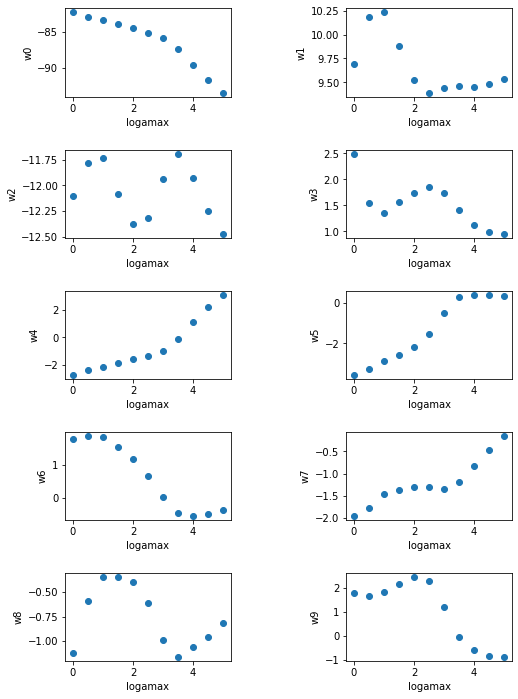

principal component weight/parameter plots generated for  logamax


<Figure size 432x288 with 0 Axes>

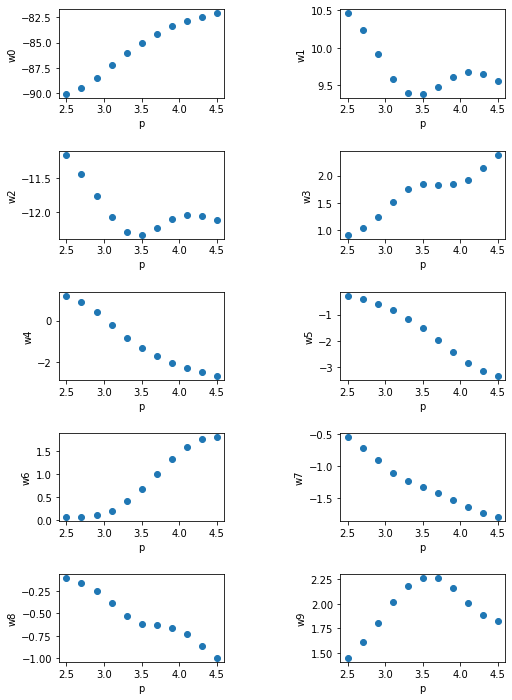

principal component weight/parameter plots generated for  p


<Figure size 432x288 with 0 Axes>

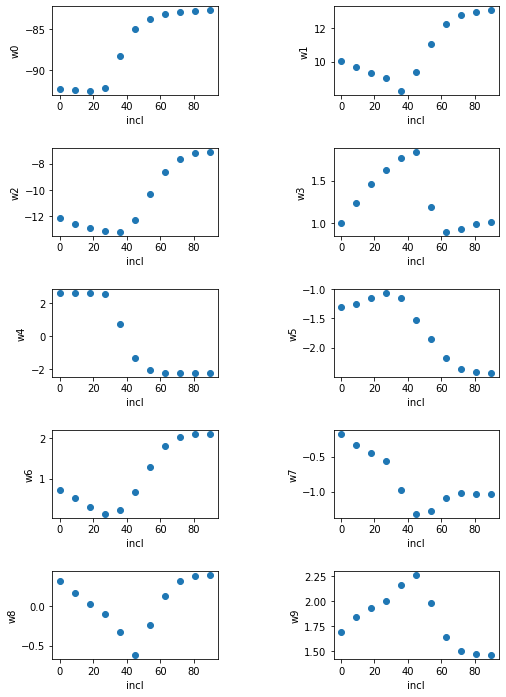

principal component weight/parameter plots generated for  incl


<Figure size 432x288 with 0 Axes>

In [61]:
for i in range(len(param_names)):
    plotpcwpar_all(i)

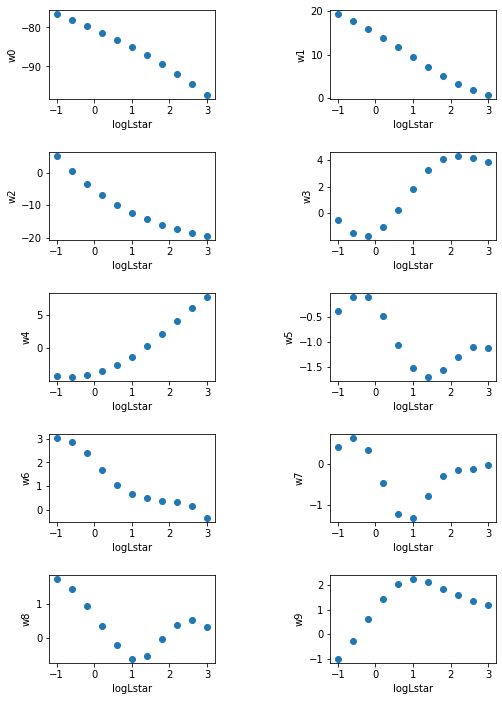

principal component weight/parameter plots generated for  logLstar


<Figure size 432x288 with 0 Axes>

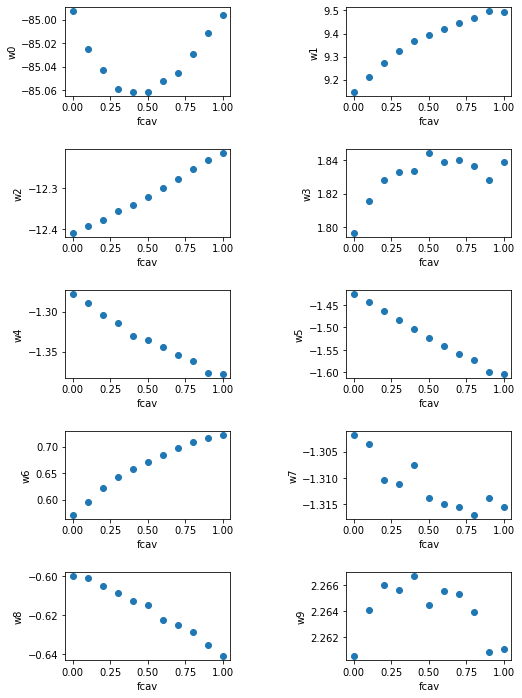

principal component weight/parameter plots generated for  fcav


<Figure size 432x288 with 0 Axes>

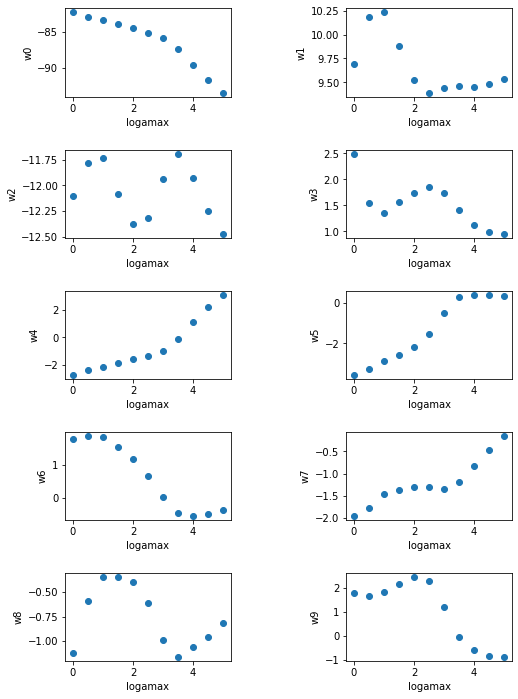

principal component weight/parameter plots generated for  logamax


<Figure size 432x288 with 0 Axes>

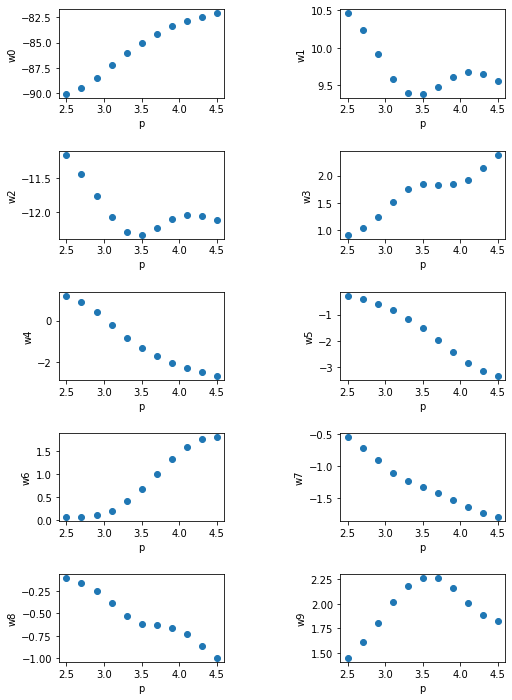

principal component weight/parameter plots generated for  p


<Figure size 432x288 with 0 Axes>

In [87]:
for i in [1,10,12,13]:
    plotpcwpar_all(i)

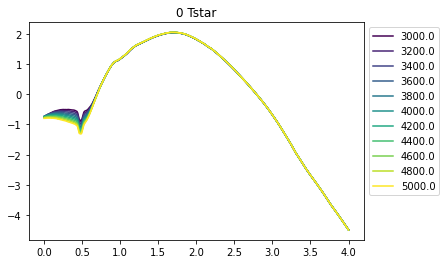

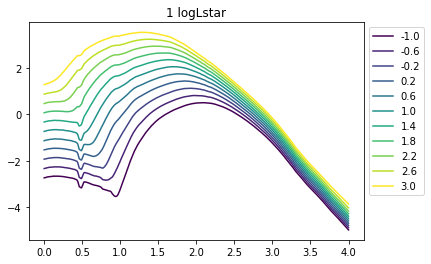

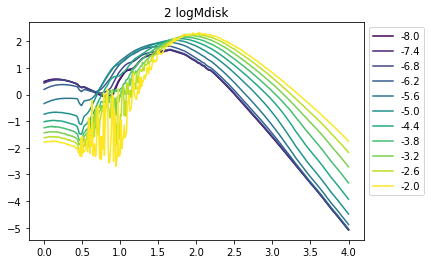

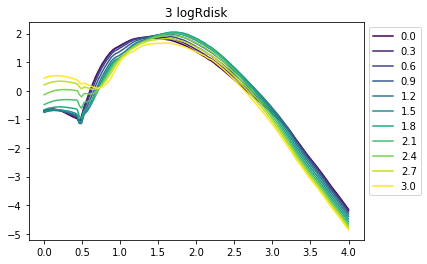

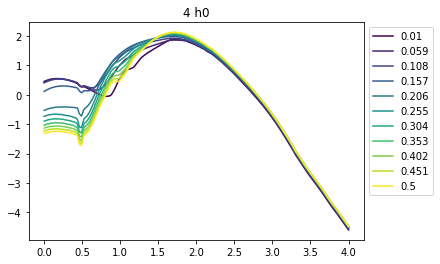

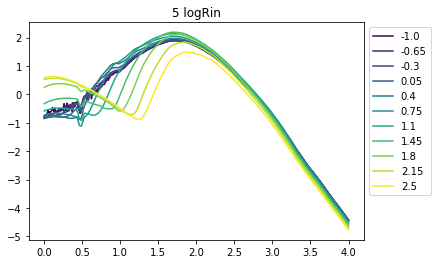

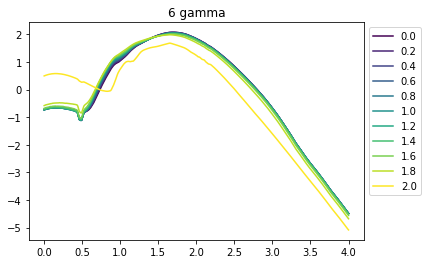

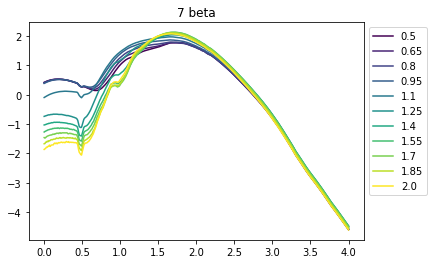

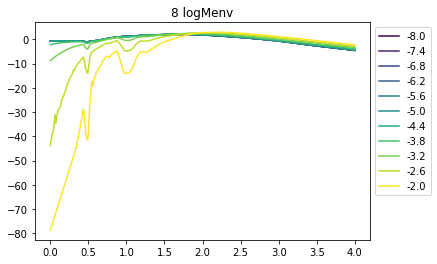

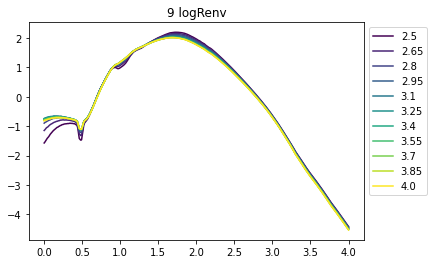

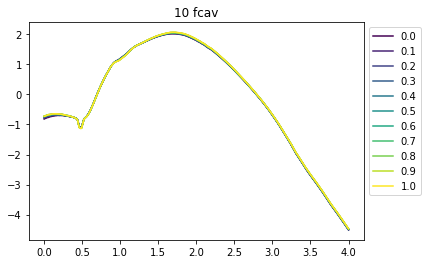

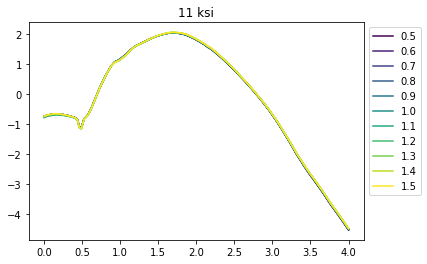

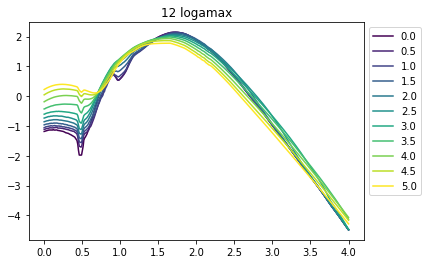

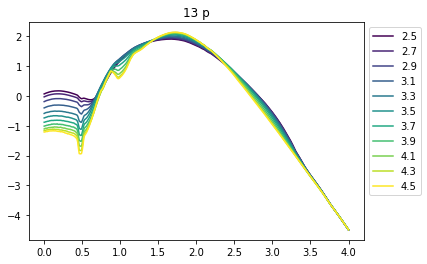

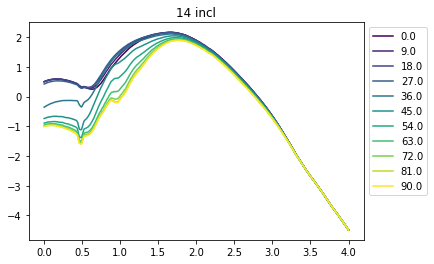

In [82]:
colors= plt.cm.viridis(np.linspace(0,1,11))

for j in range(15):
    for i in range(11):
        plt.plot(np.log10(xvals),slicevals[j][i],c=colors[i],label=str(np.round(sliceparams[j][i],3)))
    plt.title(str(j)+" "+param_names[j])
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

In [83]:
def sedcomp(seds,ncomp=15):
    fig,ax=plt.subplots(1,figsize=(12,9))
    coeffs=pca.transform(slice_seds_msub[param][model].reshape(1,-1))
    reconst=np.dot(coeffs[0][0:ncomp],eigenseds[0:ncomp,0:nfeat]) \
            +pca.mean_[0:nfeat]+np.nanmean(nanslicevals[param][model])    
    ax.plot(np.log10(xvals)[0:nfeat], reconst, c='b',label="reconstructed SED, ncomp="+str(ncomp))
    ax.plot(np.log10(xvals)[0:nfeat], slicevals[param][model][0:nfeat], c='black',label="pdspy SED")
    plt.legend()
    plt.title("reconstructed SED of "+param_names[param]+"="+str(steps[param][model])+" model against pdspy SED")
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.show()

In [4]:
priors=[[0,30]\
        ,[-5,5]\
        ,[-8,3]\
        ,[-7,2.2]\
        ,[-10,-1.4]\
        ,[-7,2.5]\
        ,[-10,0]\
        ,[-9,1]\
        ,[-11,0]\
        ,[-14,0.3]\
        ,[-10,5]\
        ,[-10,2]\
        ,[-5,5]\
        ,[-10,2]\
        ,[-4.6,1.4]]

for i in range(len(priors)):
    priors[i].append(priors[i][1]-priors[i][0])

np.save("./priors.npy",priors)